# Setup

In [ ]:
import logging
import os 
import warnings
import platform

warnings.filterwarnings("ignore")
if "macOS" in platform.platform():
    os.chdir("/Users/erjo3868/repos/hypedsearch/hypedsearch")
# Running on Fiji
else:
    os.chdir("/scratch/Shares/layer/hypedsearch/hypedsearch")


# Ensure only one logger is configured
# Remove existing handlers if any
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to ensure only one handler
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()]
)

from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
from typing import List, Optional, Dict

from src.constants import ION_INT_TO_TYPE, FULL_NAME, DEFAULT_PPM_TOLERANCE, COMET_COUNTS, IonTypes, MOUSE_PROTEOME
from src.utils import flatten_list_of_lists, pickle_and_compress, decompress_and_unpickle
from src.plot_utils import fig_setup, finalize, set_title_axes_labels
from src.peptides_and_ions import Peptide, get_unique_peptides, write_fasta
from src.mass_spectra import Spectrum, Peak
from src.peptide_spectrum_comparison import Cluster
from src.protein_product_ion_database import get_aa_seq_from_db, ProteinProductIonDb, PeakWithMatchingProductIons, IonWithSeq
from src.comet_utils import CometRow
from scripts.analyze_comet_psms import PSM

NUM_CPUS = multiprocessing.cpu_count()
print(f"Total available CPUs (physical and logical (hyperthreaded)): {NUM_CPUS}")

Total available CPUs (physical and logical (hyperthreaded)): 12


# Protein-product ion database

## Time it takes to make, index, and query the database [LU: 2/28/25]

True

Text(0.5, 0.98, 'charges=[1,2,3]; queryKmerSize=15; numRepeats=1')

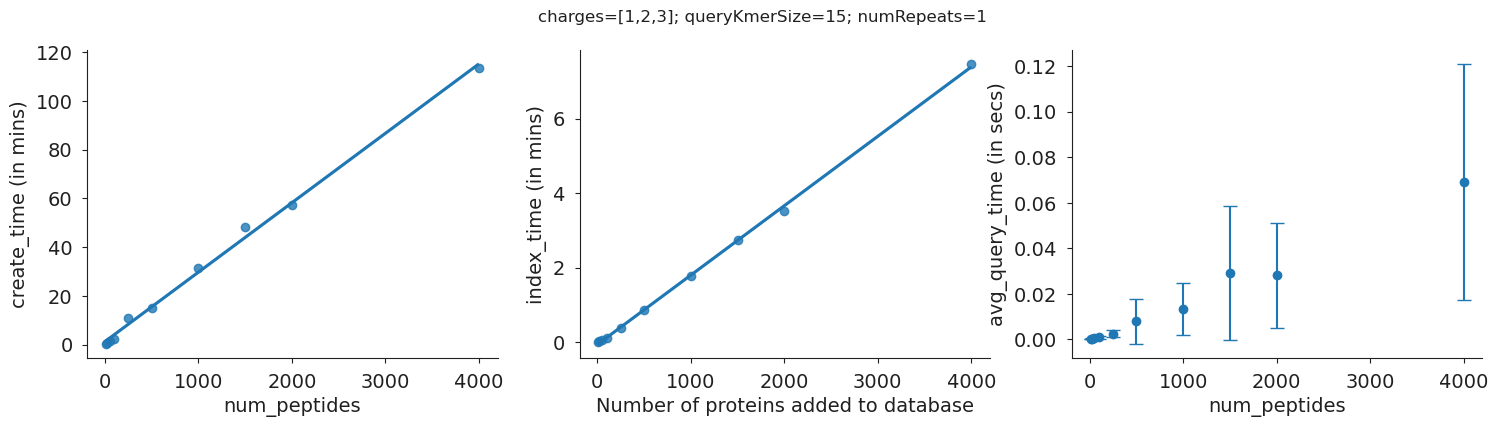

In [ ]:

from pathlib import Path
import seaborn as sns
import pandas as pd
from src.utils import decompress_and_unpickle
from scripts.db_creation_indexing_querying_timing import ExperimentResult, ExperimentParams
import matplotlib.pyplot as plt


output_dir = Path('results/db_timing_os=FIJI_charges=[1, 2, 3]_queryKmerSize=15_numRepeats=1')
# output_dir = Path("results/db_timing_os=FIJI_charges=[1, 2, 3]_queryKmerSize=15_numRepeats=10")
output_dir.exists()

dfs = []
for f in list(output_dir.glob("*")):
    result = decompress_and_unpickle(f)
    dfs.append(result.df)

data = pd.concat(dfs, ignore_index=True)


np = "num_peptides"
_, axs = fig_setup(1, 3)
colm, plot_idx = "create_time", 0
x, y = data[np], data[colm]/60 # divide by 60 to get time in mins
ax = axs[plot_idx]
_=sns.regplot(
    x=x, y=y,
    ax=ax,
    ci=0
)
set_title_axes_labels(ax=ax,
    xlabel=np,
    ylabel=colm + " (in mins)",                      
)

colm, plot_idx = "index_time", 1
x, y = data[np], data[colm]/60 # divide by 60 to get time in mins
ax = axs[plot_idx]
_=sns.regplot(
    x=x, y=y,
    ax=ax,
    ci=0
)

set_title_axes_labels(ax=ax,
    xlabel="Number of proteins added to database",
    ylabel=colm + " (in mins)",                      
)



colm, plot_idx = "avg_query_time", 2
x, y = data[np], data[colm]
y_sd = data["sd_query_time"]
ax = axs[plot_idx]
_=ax.errorbar(x, y, yerr=y_sd, fmt='o', capsize=5)
set_title_axes_labels(
    ax=ax,
    xlabel=np,
    ylabel=colm + " (in secs)"
)


plt.suptitle("charges=[1,2,3]; queryKmerSize=15; numRepeats=1")
finalize(axs)



In [101]:
from scripts.db_creation_indexing_querying_timing import ExperimentResult, ExperimentParams
from src.utils import decompress_and_unpickle

# path = "results/TESTING_db_timing_os=MAC_charges=[1, 2, 3]_queryKmerSize=15_numRepeats=1/10.pkl"
# path = "results/TESTING_db_timing_os=MAC_charges=[1, 2, 3]_queryKmerSize=15_numRepeats=3/10.pkl"
output_dir = "results/TESTING_db_timing_os=MAC_charges=[1, 2, 3]_queryKmerSize=15_numRepeats=10/10.pkl"
x = decompress_and_unpickle(output_dir)
x.params
x.df

ExperimentParams(testing=True, num_peptides_to_add=10, num_repeats=10, charges=[1, 2, 3], ion_types=[<IonTypes.B_ION_TYPE: 'b'>, <IonTypes.Y_ION_TYPE: 'y'>], query_kmer_size=15, num_mass_queries=100, fasta_path=PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/fastas/Uniprot_mouse.fasta'), ppm_tolerance=10)

,num_peptides,create_time,index_time,avg_query_time,sd_query_time,num_product_ions
0,10,4.182412,0.214175,0.000047,0.000025,695850
1,10,3.151714,0.168609,0.000030,0.000013,530250
2,10,2.314053,0.114278,0.000026,0.000015,380550
3,10,4.479055,0.236106,0.000047,0.000026,752250
4,10,5.700118,0.303399,0.000051,0.000032,948600
5,10,5.196392,0.280944,0.000053,0.000026,868410
6,10,5.860973,0.312890,0.000045,0.000024,975300
7,10,3.295713,0.173424,0.000039,0.000017,543150
8,10,3.733313,0.197260,0.000037,0.000018,627900
9,10,7.285569,0.468627,0.000064,0.000042,1189650


# Find the unique peptides in the mouse proteome

In [ ]:
fasta_path = MOUSE_PROTEOME

proteins = Peptide.from_fasta(fasta_path=fasta_path)

out_path = "tmp/test.fasta"

write_fasta(peptides=proteins[:10], output_path=out_path)



2025-03-09 19:30:59,175 - src.peptides_and_ions - INFO - Processing protein 1 of 21759
2025-03-09 19:30:59,181 - src.peptides_and_ions - INFO - Processing protein 2 of 21759
2025-03-09 19:30:59,198 - src.peptides_and_ions - INFO - Processing protein 3 of 21759
2025-03-09 19:30:59,244 - src.peptides_and_ions - INFO - Processing protein 4 of 21759
2025-03-09 19:30:59,259 - src.peptides_and_ions - INFO - Processing protein 5 of 21759
2025-03-09 19:30:59,422 - src.peptides_and_ions - INFO - Processing protein 6 of 21759
2025-03-09 19:30:59,442 - src.peptides_and_ions - INFO - Processing protein 7 of 21759
2025-03-09 19:30:59,550 - src.peptides_and_ions - INFO - Processing protein 8 of 21759
2025-03-09 19:30:59,561 - src.peptides_and_ions - INFO - Processing protein 9 of 21759
2025-03-09 19:30:59,574 - src.peptides_and_ions - INFO - Processing protein 10 of 21759
2025-03-09 19:30:59,779 - src.peptides_and_ions - INFO - Processing protein 11 of 21759
2025-03-09 19:30:59,809 - src.peptides_an

KeyboardInterrupt: 

# Number of total k-mers vs unique k-mers in mouse proteome

In [ ]:
from tqdm import tqdm
from src.peptides_and_ions import Peptide, get_unique_kmers
from src.constants import MOUSE_PROTEOME
import pandas as pd

peptides = Peptide.from_fasta(fasta_path=MOUSE_PROTEOME)

k_vals = list(range(1, 26))
rows = []
for k in tqdm(k_vals):
    num_total_kmers = sum([
        (len(peptide.seq) - k +  1) 
        for peptide in peptides
    ])
    num_uniq_kmers = len(get_unique_kmers(peptides=peptides, k=k))
    rows.append([k, num_total_kmers, num_uniq_kmers])
    valid_prots_df = pd.DataFrame(rows, columns=["k", "total_kmers", "uniq_kmers"])

100%|██████████| 25/25 [11:24<00:00, 27.37s/it]


In [ ]:
from src.plot_utils import fig_setup, finalize, set_

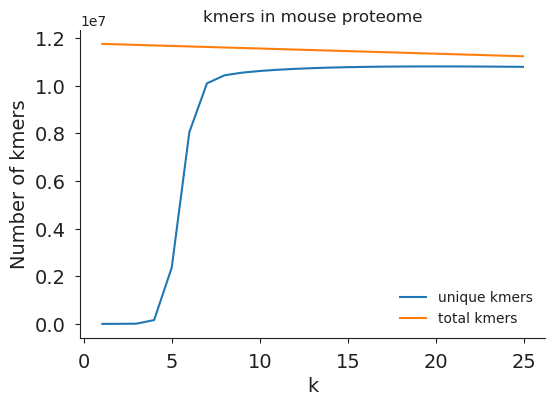

In [ ]:
from src.plot_utils import fig_setup, finalize, set_title_axes_labels

_, axs = fig_setup()
ax = axs[0]

ax.plot(valid_prots_df["k"], valid_prots_df["uniq_kmers"], label="unique kmers")
ax.plot(valid_prots_df["k"], valid_prots_df["total_kmers"], label="total kmers")
set_title_axes_labels(ax=ax, xlabel="k", ylabel="Number of kmers", title="kmers in mouse proteome")
finalize(axs)



# Proteins in mouse proteome vs Comet run 1 [LU: 2/28/25]

In [178]:
from src.comet_utils import load_comet_data, CometRow
from src.peptides_and_ions import get_proteins_from_fasta
from src.utils import flatten_list_of_lists

comet_df = load_comet_data()
# comet_df.head(2)
comet_rows = CometRow.from_dataframe(comet_df)
all_comet_proteins = flatten_list_of_lists([row.proteins for row in comet_rows])
uniq_comet_proteins = set(all_comet_proteins)
fasta_proteins = get_proteins_from_fasta(fasta_path=MOUSE_PROTEOME)


2025-03-03 21:24:07,480 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn4
2025-03-03 21:24:07,511 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn5
2025-03-03 21:24:07,537 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn6
2025-03-03 21:24:07,564 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn7
2025-03-03 21:24:07,588 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn8
2025-03-03 21:24:07,614 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn9


Number of unique Comet proteins = 16174
Minimum Comet protein abundance = 1, max = 971
Number of proteins in mouse proteome = 21759


,x,number_proteins_gt_x-1_le_x
0,1,4369
1,2,3040


(0.0, 50.0)

,x,number_proteins_gt_x
0,0,16174
1,1,11805


(10.0, 50.0)

(-1.0, 1000.0)

Text(0.5, 0.98, 'Comet run 1 data')

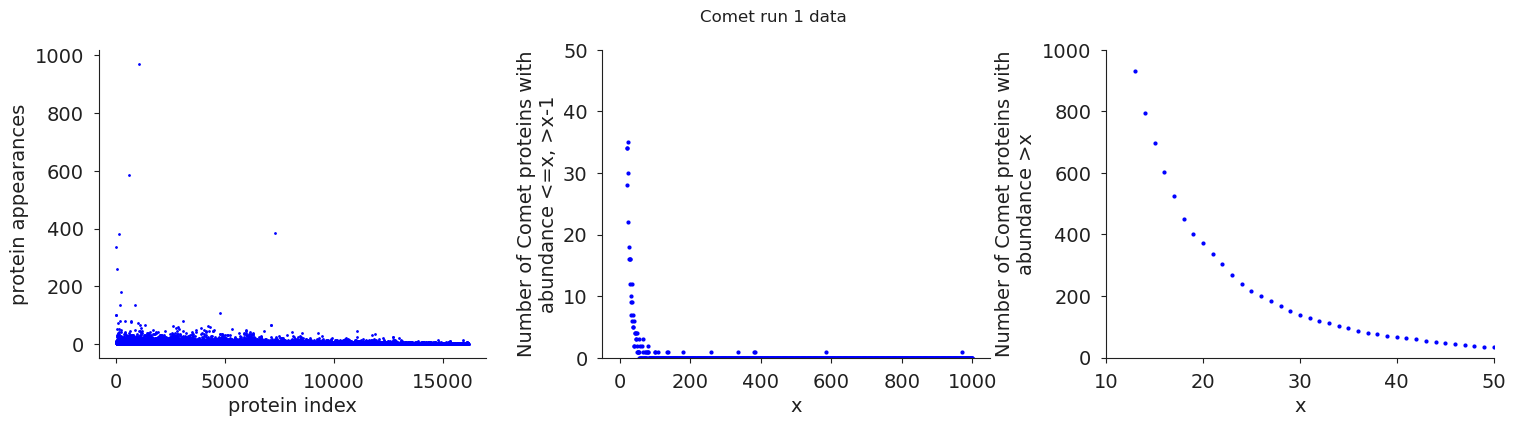

In [179]:
from typing import Counter
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

print(f"Number of unique Comet proteins = {len(uniq_comet_proteins)}")
assert len(fasta_proteins) == len(set([protein.name for protein in fasta_proteins])), "Why aren't the number of proteins in the fasta the same as the number of unique proteins?"
comet_protein_abundances = np.array(list(Counter(all_comet_proteins).values()))
print(f"Minimum Comet protein abundance = {min(comet_protein_abundances)}, max = {max(comet_protein_abundances)}")
print(f"Number of proteins in mouse proteome = {len(fasta_proteins)}")

_, axs = fig_setup(1, 3)
ax = axs[0]
_=ax.plot(
    comet_protein_abundances,
    "bo",
    ms=1,
)
set_title_axes_labels(
    ax=ax, 
    xlabel="protein index", 
    ylabel="protein appearances",
    # title="Number of times protein appears in Comet run 1 data"
)
finalize(axs)

precursor_charges = []
prev_val = 0
for val in range(1, 1001):
    precursor_charges.append([val, sum((comet_protein_abundances>prev_val) & (comet_protein_abundances<=val))])
    # data.append([val, sum((comet_protein_abundances<=val))])
    prev_val = val
colm1, colm2 = "x", "number_proteins_gt_x-1_le_x"
precursor_charges = pd.DataFrame(precursor_charges, columns=[colm1, colm2])
precursor_charges.head(2)

# _, axs = fig_setup()
ax = axs[1]
_=ax.plot(
    precursor_charges[colm1], precursor_charges[colm2],
    "bo",
    ms=2
)
set_title_axes_labels(
    ax=ax, 
    xlabel="x", 
    ylabel="Number of Comet proteins with\nabundance <=x, >x-1",
    # title="Number of times protein appears in Comet run 1 data"
)
ax.set_ylim(0, 50)
finalize(axs)

precursor_charges = []
for val in range(0, 1001):
    precursor_charges.append([val, sum((comet_protein_abundances>val))])
colm1, colm2 = "x", "number_proteins_gt_x"
precursor_charges = pd.DataFrame(precursor_charges, columns=[colm1, colm2])
precursor_charges.head(2)

# _, axs = fig_setup()
ax = axs[2]
_=ax.plot(
    precursor_charges[colm1], precursor_charges[colm2],
    "bo",
    ms=2
)
set_title_axes_labels(
    ax=ax, 
    xlabel="x", 
    ylabel="Number of Comet proteins with\nabundance >x",
    # title="Number of times protein appears in Comet run 1 data"
)
plt.xlim(left=10, right=50)
plt.ylim(top=1000, bottom=-1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle("Comet run 1 data")
finalize(axs)


(5, 35213, 540.6160669148398, 389.0)

<Axes: ylabel='Density'>

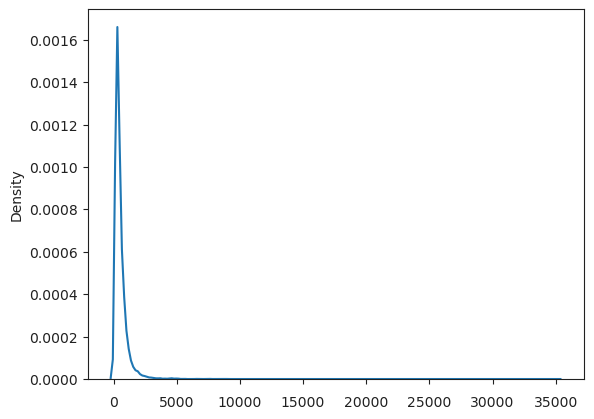

In [289]:
mouse_proteome = get_proteins_from_fasta(fasta_path=MOUSE_PROTEOME)
prot_sizes = [len(protein.seq) for protein in mouse_proteome]

min(prot_sizes), max(prot_sizes), np.mean(prot_sizes), np.median(prot_sizes)
sns.kdeplot(
    data=prot_sizes
)


# Analyze Comet PSMs [LU: 3/3/25]

Text(0.5, 0.98, 'High-scoring Comet-produced PSMs')

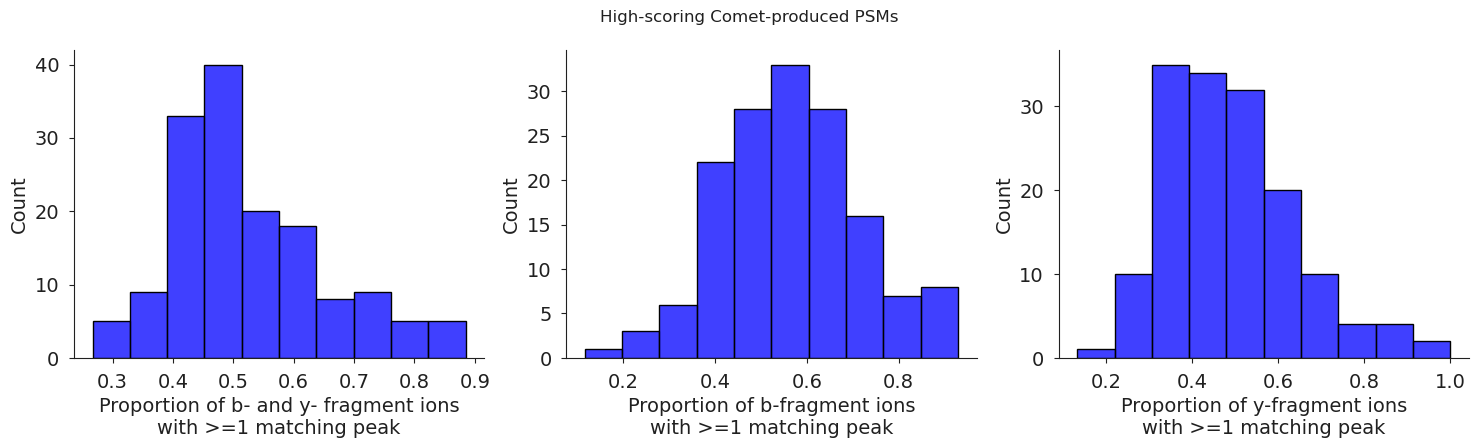

In [5]:
# Also see scripts/analyze_comet_psms.py

tmp = "results/high_scoring_comet_psms_ppmTol=10_peakFilter=0"
# tmp = "results/comet_psms_ppmTol=10_peakFilter=0"
output_dir = Path(tmp)

# Get proportions of fragment ions with a peak match
props = []
b_props = []
y_props = []
results = []
for path in list(output_dir.glob("*.pkl")):
    psm = decompress_and_unpickle(path)

    # Get proportion of b-ions and y-ions with a match
    num_b_ions, num_y_ions = 0, 0
    num_b_matches, num_y_matches = 0, 0
    for key, value in psm.psm.num_peaks_matching_product_ion.items():
        if key[1] == "b":
            num_b_ions += 1
            if value > 0:
                num_b_matches += 1
        if key[1] == "y":
            num_y_ions += 1
            if value > 0:
                num_y_matches += 1
        # break
    prop = psm.psm.num_product_ions_with_match / psm.psm.num_product_ions
    b_prop = num_b_matches/num_b_ions
    y_prop = num_y_matches/num_y_ions
    props.append(prop)
    b_props.append(b_prop)
    y_props.append(y_prop)

    results.append([psm, prop, b_prop, y_prop])    # break


_, axs = fig_setup(1, 3)
ax = axs[0]
_=sns.histplot(
    props,
    bins=10,
    # kde=True,
    color="blue",
    edgecolor="black",
    ax=ax,
)
set_title_axes_labels(ax=ax, ylabel="Count", xlabel="Proportion of b- and y- fragment ions\nwith >=1 matching peak")
# finalize(axs)

# _, axs = fig_setup()
ax = axs[1]
_=sns.histplot(
    b_props,
    bins=10,
    # kde=True,
    color="blue",
    edgecolor="black",
    ax=ax,
)
set_title_axes_labels(ax=ax, ylabel="Count", xlabel="Proportion of b-fragment ions\nwith >=1 matching peak")
# finalize(axs)

# _, axs = fig_setup()
ax = axs[2]
_=sns.histplot(
    y_props,
    bins=10,
    # kde=True,
    color="blue",
    edgecolor="black",
    ax=ax,
)
set_title_axes_labels(ax=ax, ylabel="Count", xlabel="Proportion of y-fragment ions\nwith >=1 matching peak")
finalize(axs)
plt.suptitle("High-scoring Comet-produced PSMs")
# props
# b_props
# y_props



## Create protein-product ion DB for proteins with most Comet counts

In [145]:
from src.constants import COMET_COUNTS, FULL_NAME, RESULTS_DIR
from src.peptides_and_ions import get_proteins_by_name
from src.protein_product_ion_database import ProteinProductIonDb, create_and_populate_protein_and_product_ion_database



fasta_path = MOUSE_PROTEOME
top_n_most_abundant_proteins = 3
out_path = (
    RESULTS_DIR / f"db_{top_n_most_abundant_proteins}_most_abundant_comet_prots.db"
)
if out_path.exists():
    msg = "Database already exists! Exiting."
    print(msg)
    out_path.unlink()
    
protein_abundances = decompress_and_unpickle("results/protein_abundances.pkl")
protein_abundances.sort_values(COMET_COUNTS, ascending=False, inplace=True, ignore_index=True)
protein_names = list(protein_abundances[:top_n_most_abundant_proteins][FULL_NAME])
# protein_names = list(protein_abundances[:top_n_most_abundant_proteins]["full_name"])
# # protein_names, len(protein_names)

db_proteins = get_proteins_by_name(fasta_path=fasta_path, protein_names=protein_names)
db_proteins
# start_time = time()
create_and_populate_protein_and_product_ion_database(
    peptides=db_proteins,
    db_path=out_path,
)

# df = ProteinProductIonDb(db_path="results/db_3_most_abundant_comet_prots.db")


[Peptide(seq='MALWMRFLPLLALLFLWESHPTQAFVKQHLCGSHLVEALYLVCGERGFFYTPMSRREVEDPQVAQLELGGGPGAGDLQTLALEVAQQKRGIVDQCCTSICSLYQLENYCN', name='sp|P01326|INS2_MOUSE', desc='sp|P01326|INS2_MOUSE Insulin-2 OS=Mus musculus OX=10090 GN=Ins2 PE=1 SV=1', id=3116),
 Peptide(seq='MQPAMLLGLLGAAALAAVSSAPVDNRDHNEEMVTRCIIEVLSNALSKSSVPTITPECRQVLKKSGKEVKGEEKGENQNSKFEVRLLRDPADASGTRWASSREDAGAPVEDSQGQTKVGNEKWTEGGGHSREGVDDQESLRPSNQQASKEAKIYHSEERVGKEREKEEGKIYPMGEHREDAGEEKKHIEDSGEKPNTFSNKRSEASAKKKDESVARADAHSMELEEKTHSREQSSQESGEETRRQEKPQELTDQDQSQEESQEGEEGEEGEEGEEGEEDSASEVTKRRPRHHHGRSGSNKSSYEGHPLSEERRPSPKESKEADVATVRLGEKRSHHLAHYRASEEEPEYGEESRSYRGLQYRGRGSEEDRAPRPRSEESQEREYKRNHPDSELESTANRHGEETEEERSYEGANGRQHRGRGREPGAHSALDTREEKRLLDEGHYPVRESPIDTAKRYPQSKWQEQEKNYLNYGEEGDQGRWWQQEEQLGPEESREEVRFPDRQYEPYPITEKRKRLGALFNPYFDPLQWKNSDFEKRGNPDDSFLEDEGEDRNGVTLTEKNSFPEYNYDWWERRPFSEDVNWGYEKRSFARAPQLDLKRQYDGVAELDQLLHYRKKADEFPDFYDSEEQMGPHQEANDEKARADQRVLTAEEKKELENLAAMDLELQKIAEKFSQRG', name='sp|P16014|SCG1_MOUSE', desc='sp|P16014|SCG1_MOUSE Se

2025-03-06 16:32:10,512 - src.protein_product_ion_database - INFO - Creating protein-product ion database...
2025-03-06 16:32:10,515 - src.sql_database - INFO - Created table proteins
2025-03-06 16:32:10,516 - src.sql_database - INFO - Created table product_ions
2025-03-06 16:32:10,516 - src.protein_product_ion_database - INFO - Adding protein 1 / 3...
2025-03-06 16:32:10,880 - src.protein_product_ion_database - INFO - Adding protein 2 / 3...
2025-03-06 16:32:13,490 - src.protein_product_ion_database - INFO - Adding protein 3 / 3...


## Get ions that match the spectrum

In [18]:
def get_ions_matching_peak(
        peak: Peak, 
        precursor_charge: int, 
        ppm_tolerance: float = DEFAULT_PPM_TOLERANCE,
        db_path: Optional[str] = None, 
        db: Optional[ProteinProductIonDb] = None,
    ):
    if db is None:
        db = ProteinProductIonDb(db_path=db_path)
    matching_ions = db.get_ions_within_mass_tolerance(
            query_mass=peak.mz, 
            ppm_tolerance=ppm_tolerance
        )

    # Filter out ions with charge > precursor charge
    charge_filtered_ions = []
    for ion in matching_ions:
        if ion.charge <= precursor_charge:
            ion_with_seq = IonWithSeq(
                ion=ion,
                seq=get_aa_seq_from_db(
                    protein_id=ion.protein_id, 
                    inclusive_start=ion.inclusive_start, 
                    exclusive_end=ion.exclusive_end, 
                    db=db
                )
            )
            charge_filtered_ions.append(ion_with_seq)
        
    return PeakWithMatchingProductIons(peak=peak, ions=charge_filtered_ions)

def process_psm(path, db, db_protein_names):
    psm = decompress_and_unpickle(path)
    row = psm.comet_row
    row = pd.DataFrame([row.values], columns=row.index)
    row = CometRow.from_dataframe(row)[0]

    row_in_db = False
    for prot in row.proteins:
        if prot in db_protein_names:
            row_in_db = True
    
    # Only use those rows that are in the database
    if not row_in_db:
        return None

    spectrum = row.get_corresponding_spectrum()
    
    # # Peak filtering
    # spectrum.filter_to_top_n_peaks(n=top_n)

    peaks_with_matches = []
    num_peaks = len(spectrum.peaks)
    for peak_idx, peak in enumerate(spectrum.peaks):
        print(f"Peak {peak_idx + 1} of {num_peaks}")
        matching_ions = db.get_ions_within_mass_tolerance(
            query_mass=peak.mz, 
            ppm_tolerance=DEFAULT_PPM_TOLERANCE
        )

        # Filter out ions with charge > precursor charge
        charge_filtered_ions = []
        for ion in matching_ions:
            if ion.charge <= spectrum.precursor_charge:
                ion_with_seq = IonWithSeq(
                    ion=ion,
                    seq=get_aa_seq_from_db(
                        protein_id=ion.protein_id, 
                        inclusive_start=ion.inclusive_start, 
                        exclusive_end=ion.exclusive_end, 
                        db=db
                    )
                )
                charge_filtered_ions.append(ion_with_seq)
        
        # if len(charge_filtered_ions) > 0:
        peaks_with_matches.append(
            PeakWithMatchingProductIons(peak=peak, ions=charge_filtered_ions)
        )
    return peaks_with_matches


   
top_n_prots = 100
top_n_peaks = 50
db_path = f"results/db_{top_n_prots}_most_abundant_comet_prots.db"
db = ProteinProductIonDb(db_path=db_path)

protein_abundances = decompress_and_unpickle("results/protein_abundances.pkl")
protein_abundances.sort_values(COMET_COUNTS, ascending=False, inplace=True, ignore_index=True)
db_protein_names = list(protein_abundances[:top_n_prots][FULL_NAME])

output_dir = Path("results/high_scoring_comet_psms_ppmTol=10_peakFilter=0")
for path in list(output_dir.glob("*.pkl")):
    start_time = time()
    # process_psm(db=db, db_protein_names=db_protein_names, path)
    psm = decompress_and_unpickle(path)
    row = psm.comet_row
    row = pd.DataFrame([row.values], columns=row.index)
    row = CometRow.from_dataframe(row)[0]

    row_in_db = False
    for prot in row.proteins:
        if prot in db_protein_names:
            row_in_db = True
    
    # Only use those rows that are in the database
    if not row_in_db:
        continue

    spectrum = row.get_corresponding_spectrum()
    
    # Peak filtering
    spectrum.filter_to_top_n_peaks(n=top_n_peaks)

    # Get ions that match the spectrum peaks
    process_peak = lambda peak: get_ions_matching_peak(db_path=db_path, peak=peak, precursor_charge=spectrum.precursor_charge)
    with ThreadPoolExecutor(max_workers=NUM_CPUS) as executor:
        peaks_with_matches = list(executor.map(process_peak, spectrum.peaks))
    break


### No parallelization

In [20]:
# No parallelization
start_time = time()
peaks_with_matches = []
for peak in spectrum.peaks:
    peaks_with_matches.append(get_ions_matching_peak(db=db, peak=peak, precursor_charge=spectrum.precursor_charge))
print(f"Took {round(time() - start_time, 2)} seconds")

Took 179.29 seconds


### ThreadPoolExecutor

In [ ]:
# concurrent.futures.ThreadPoolExecutor (for I/O-bound tasks)
from concurrent.futures import ThreadPoolExecutor

process_peak = lambda peak: get_ions_matching_peak(db_path=db_path, peak=peak, precursor_charge=spectrum.precursor_charge)

start_time = time()
with ThreadPoolExecutor(max_workers=NUM_CPUS) as executor:
    peaks_with_matches = list(executor.map(process_peak, spectrum.peaks))
print(f"Took {round(time() - start_time, 2)} seconds")

NameError: name 'spectrum' is not defined

### ProcessPoolExecutor -- DOESN'T WORK

In [ ]:
# concurrent.futures.ProcessPoolExecutor (for CPU-bound tasks)
from concurrent.futures import ProcessPoolExecutor

num_workers = multiprocessing.cpu_count()
process_peak = lambda peak: get_ions_matching_peak(db_path=db_path, peak=peak, precursor_charge=spectrum.precursor_charge)

start_time = time()
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    peaks_with_matches = list(executor.map(process_peak, spectrum.peaks))
print(f"Took {round(time() - start_time, 2)} seconds")

## Clusters

In [38]:

data = pd.DataFrame()
all_ions = flatten_list_of_lists([match.ions for match in peaks_with_matches])
data = [
    [ion.ion.protein_id, ion.ion.inclusive_start, ion.ion.exclusive_end, ION_INT_TO_TYPE[ion.ion.ion_type], ion.ion.charge, ion.seq, ion.ion] 
    for ion in all_ions
]
data = pd.DataFrame(
    data,
    columns=["p_id", "i_start", "e_end", "type", "charge", "seq", "ion"]
)
# data.head(3)

# b-clusters
b_clusters = []
cluster_type = IonTypes.B_ION_TYPE
for name, group in data.groupby(["p_id", "i_start"]):
    b_clusters.append(Cluster(ions=list(group["ion"]), ion_type=cluster_type))


# y-clusters
y_clusters = []
cluster_type = IonTypes.Y_ION_TYPE
for name, group in data.groupby(["p_id", "e_end"]):
    y_clusters.append(Cluster(ions=list(group["ion"]), ion_type=cluster_type))

cluster_support = []
for cluster in b_clusters:
    cluster_support.append([cluster.get_aa_seq(db=db), cluster.num_supporting_ions, "b", cluster])
for cluster in y_clusters:
    cluster_support.append([cluster.get_aa_seq(db=db), cluster.num_supporting_ions, "y", cluster])

df = pd.DataFrame(cluster_support, columns=["seq", "support", "type", "cluster"])
df["len"] = df["seq"].apply(lambda seq: len(seq))
df["support/len"] = df["support"] / df["len"]

(103792, 5)

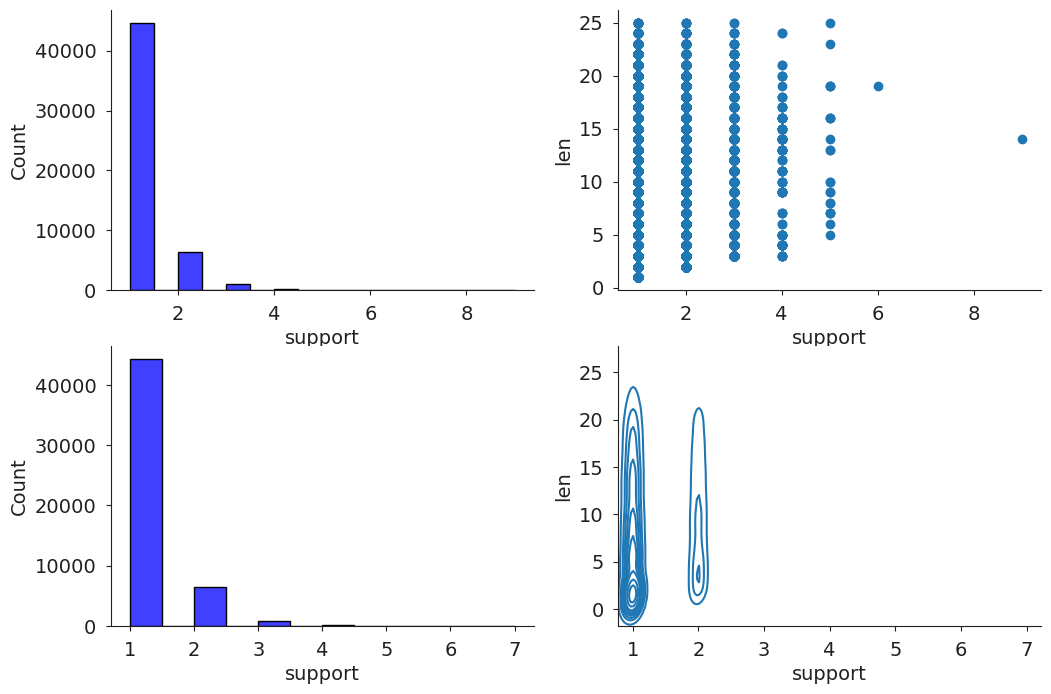

In [29]:


_, axs = fig_setup(2, 2)
ax = axs[0]
_=sns.histplot(
    df[df.type=="b"]["support"],
    # bins=10,
    binwidth=0.5,
    # kde=True,
    color="blue",
    edgecolor="black",
    ax=ax,
)
set_title_axes_labels(ax=ax, ylabel="Count", xlabel="support")

ax = axs[1]
_=ax.scatter(
    df[df.type=="b"]["support"], df[df.type=="b"]["len"],
)
set_title_axes_labels(
    ax=ax, 
    xlabel="support",
    ylabel="len", 
)

ax = axs[2]
_=sns.histplot(
    df[df.type=="y"]["support"],
    # bins=10,
    binwidth=0.5,
    # kde=True,
    color="blue",
    edgecolor="black",
    ax=ax,
)
set_title_axes_labels(ax=ax, ylabel="Count", xlabel="support")

ax = axs[3]

_=sns.kdeplot(
    x=df[df.type=="y"]["support"], 
    y=df[df.type=="y"]["len"], 
    # cmap='Blues', 
    # fill=True, 
    ax=ax,
)

# plt.imshow()
# _=ax.imshow(z+10, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
#         cmap=cm.hot, norm=LogNorm())
# _=ax.scatter(
#     df[df.type=="y"]["support"], df[df.type=="y"]["len"],
# )
set_title_axes_labels(
    ax=ax, 
    xlabel="support",
    ylabel="len", 
)
finalize(axs)
df.shape

In [58]:
bs = df[(df.type == "b") & (df.support > 6)].cluster.iloc[0].ions
ys = df[(df.type == "y") & (df.support > 6)].cluster.iloc[0].ions

db_supported_ions = []
for b in bs:
    db_supported_ions.append((b.get_aa_seq(db=db), "b"))
for y in ys:
    db_supported_ions.append((y.get_aa_seq(db=db), "y"))

supported_ions = []
for key, value in psm.psm.num_peaks_matching_product_ion.items():
    if value > 0: 
        supported_ions.append(key)

x = set(supported_ions)
y = set(db_supported_ions)

x.union(y)
x.difference(y)
y.difference(x)

{('AG', 'y'),
 ('AQLELGGGPGAG', 'y'),
 ('DPQ', 'b'),
 ('DPQV', 'b'),
 ('DPQVA', 'b'),
 ('DPQVAQ', 'b'),
 ('DPQVAQL', 'b'),
 ('DPQVAQLEL', 'b'),
 ('DPQVAQLELG', 'b'),
 ('DPQVAQLELGGG', 'b'),
 ('DPQVAQLELGGGP', 'b'),
 ('DPQVAQLELGGGPG', 'b'),
 ('ELGGGPGAG', 'y'),
 ('GEGLGLPSPQGPG', 'y'),
 ('GGGPGAG', 'y'),
 ('GPG', 'y'),
 ('GPGAG', 'y'),
 ('LELGGGPGAG', 'y'),
 ('LPSPQGPG', 'y'),
 ('PSPQGPG', 'y'),
 ('QGPG', 'y')}

{('AG', 'y'),
 ('AQLELGGGPGAG', 'y'),
 ('DPQVAQLELG', 'b'),
 ('DPQVAQLELGGGP', 'b'),
 ('ELGGGPGAG', 'y'),
 ('GGGPGAG', 'y'),
 ('GPGAG', 'y'),
 ('LELGGGPGAG', 'y')}

{('GEGLGLPSPQGPG', 'y'),
 ('GPG', 'y'),
 ('LPSPQGPG', 'y'),
 ('PSPQGPG', 'y'),
 ('QGPG', 'y')}

In [53]:
supported_ions = []
for key, value in psm.psm.num_peaks_matching_product_ion.items():
    if value > 0: 
        supported_ions.append(key)
supported_ions 
# psm.psm.num_product_ions_with_match

[('DPQ', 'b'),
 ('DPQV', 'b'),
 ('DPQVA', 'b'),
 ('DPQVAQ', 'b'),
 ('DPQVAQL', 'b'),
 ('DPQVAQLEL', 'b'),
 ('DPQVAQLELG', 'b'),
 ('DPQVAQLELGGG', 'b'),
 ('DPQVAQLELGGGP', 'b'),
 ('DPQVAQLELGGGPG', 'b'),
 ('AQLELGGGPGAG', 'y'),
 ('LELGGGPGAG', 'y'),
 ('ELGGGPGAG', 'y'),
 ('GGGPGAG', 'y'),
 ('GPGAG', 'y'),
 ('AG', 'y')]

# Run Comet

In [28]:
# See scripts/run_comet.py

blah = /Users/erjo3868/repos/hypedsearch/hypedsearch/comet/data/spectra/BMEM_AspN_Fxn4.mzML


# Comet EDA

In [ ]:
from scipy.stats import percentileofscore

comet_df = load_comet_data()
comet_df.head(2)
comet_df.shape

# Add quantile columns
colms = ["xcorr", "e-value", "delta_cn"]
for colm in colms:
    new_colm_name = f"{colm}_quantile"
    comet_df[new_colm_name] = comet_df[colm].apply(lambda val: percentileofscore(comet_df[colm], val, kind="rank")/100)

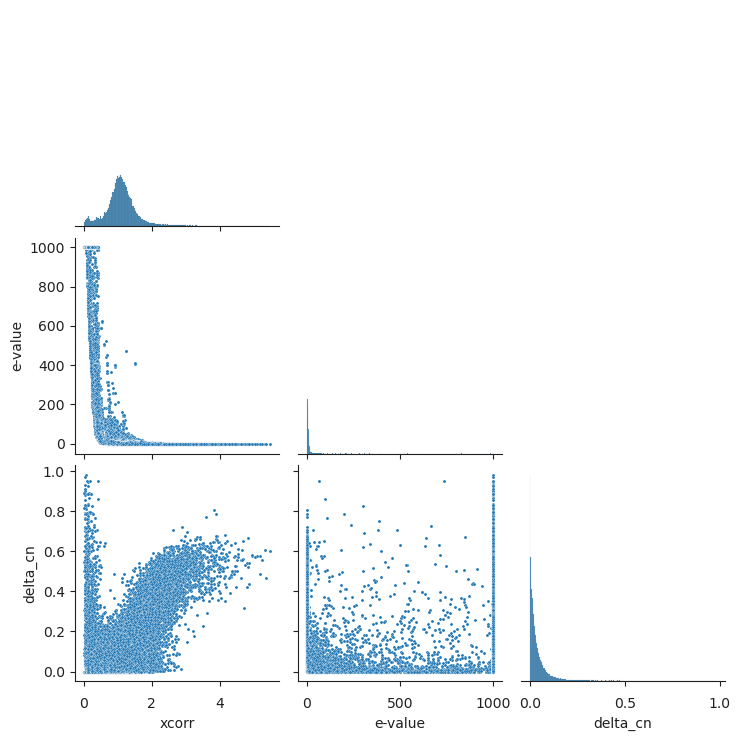

In [204]:

colms_to_plot = ["xcorr", "e-value", "delta_cn"]
_=sns.pairplot(
    comet_df[colms_to_plot],
    corner=True, 
    plot_kws={'s': 5}
)
plt.show()
# colms_to_plot = [f"{colm}_quantile" for colm in colms_to_plot]
# sns.pairplot(
#     comet_df[colms_to_plot],
#     corner=True, 
#     plot_kws={'s': 5}
# )


In [225]:
from src.utils import pickle_and_compress, decompress_and_unpickle
val = 0.005
tmp = comet_df[(comet_df["e-value_quantile"]<val) & (comet_df["delta_cn_quantile"]>1-val)]
tmp.shape[0]

# # Check that there's only one PSM per spectrum in the set
for name, group in tmp.groupby(["sample", "scan"]):
    assert group.shape[0] == 1 

tmp.reset_index(inplace=True, drop=True)

file_path = RESULTS_DIR / f"{tmp.shape[0]}_high_scoring_psms_eValQuantile<{val}_dCnQuantile>{1-val}.pkl"
pickle_and_compress(obj=tmp, file_path=file_path)
decompress_and_unpickle(file_path=file_path)


152

,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,...,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank,sample,xcorr_quantile,e-value_quantile,delta_cn_quantile
0,97,1,3,1679.850932,1679.847863,3.290000e-12,4.468,0.6426,559.0,33,...,D,"tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE,sp|P99027|RLA2_...",2,-,779.0,1,BMEM_AspN_Fxn4,0.999503,0.000112,0.998107
1,142,1,2,1470.571859,1470.568136,1.520000e-07,3.026,0.6401,989.0,15,...,D,sp|P16014|SCG1_MOUSE,1,-,785.0,1,BMEM_AspN_Fxn4,0.992330,0.003594,0.998042
2,162,1,2,1470.571859,1470.568136,3.710000e-07,2.808,0.6097,771.0,14,...,D,sp|P16014|SCG1_MOUSE,1,-,785.0,1,BMEM_AspN_Fxn4,0.988640,0.004814,0.996711
3,956,1,2,1503.673059,1503.668896,6.710000e-08,2.924,0.5913,777.0,15,...,D,sp|Q99K01|PDXD1_MOUSE,1,-,1101.0,1,BMEM_AspN_Fxn4,0.990654,0.002680,0.995812
4,975,1,2,1503.673059,1503.668896,1.330000e-08,2.640,0.6189,591.0,13,...,D,sp|Q99K01|PDXD1_MOUSE,1,-,1083.0,1,BMEM_AspN_Fxn4,0.985150,0.001460,0.997272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3047,1,2,1692.833999,1692.831879,3.610000e-07,3.431,0.6161,859.0,17,...,Q,sp|P01326|INS2_MOUSE,1,-,2261.0,1,BMEM_AspN_Fxn8,0.996326,0.004709,0.997128
148,3075,1,2,1692.833999,1692.831879,7.380000e-08,3.021,0.5909,534.0,15,...,Q,sp|P01326|INS2_MOUSE,1,-,2261.0,1,BMEM_AspN_Fxn8,0.992266,0.002840,0.995796
149,191,1,2,1123.541459,1123.539720,3.410000e-07,3.028,0.5987,981.0,14,...,-,sp|Q64433|CH10_MOUSE,1,-,1588.0,1,BMEM_AspN_Fxn9,0.992346,0.004621,0.996149
150,520,1,3,1675.881989,1675.881472,1.290000e-07,2.535,0.5803,222.0,15,...,D,sp|Q8K2T4|UQCC3_MOUSE,1,-,1811.0,1,BMEM_AspN_Fxn9,0.982422,0.003297,0.995018


[CometRow(sample='BMEM_AspN_Fxn4', scan=97, ions_matched=33, proteins=['tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE', 'sp|P99027|RLA2_MOUSE'], protein_count=2, proposed_peptide='PGSAAPAAGSAPAAAEEKK'),
 CometRow(sample='BMEM_AspN_Fxn4', scan=142, ions_matched=15, proteins=['sp|P16014|SCG1_MOUSE'], protein_count=1, proposed_peptide='DSEEQMGPHQEAN'),
 CometRow(sample='BMEM_AspN_Fxn4', scan=162, ions_matched=14, proteins=['sp|P16014|SCG1_MOUSE'], protein_count=1, proposed_peptide='DSEEQMGPHQEAN'),
 CometRow(sample='BMEM_AspN_Fxn4', scan=540, ions_matched=16, proteins=['sp|P62259|1433E_MOUSE'], protein_count=1, proposed_peptide='DMQGDGEEQNKEALQ'),
 CometRow(sample='BMEM_AspN_Fxn4', scan=975, ions_matched=13, proteins=['sp|Q99K01|PDXD1_MOUSE'], protein_count=1, proposed_peptide='GSDAVSETSSVSHIE'),
 CometRow(sample='BMEM_AspN_Fxn4', scan=1031, ions_matched=13, proteins=['sp|Q9QXW9|LAT2_MOUSE'], protein_count=1, proposed_peptide='VVYPQEGNSGAEETT'),
 CometRow(sample='BMEM_AspN_Fxn4', scan=1370, ions_matched

# MZML EDA

In [ ]:
from src.mass_spectra import load_mzml_data

spectra = load_mzml_data()

Reading sample BMEM_AspN_Fxn4's MZML
Reading sample BMEM_AspN_Fxn5's MZML
Reading sample BMEM_AspN_Fxn6's MZML
Reading sample BMEM_AspN_Fxn7's MZML
Reading sample BMEM_AspN_Fxn8's MZML
Reading sample BMEM_AspN_Fxn9's MZML


## Precursor charge distribution

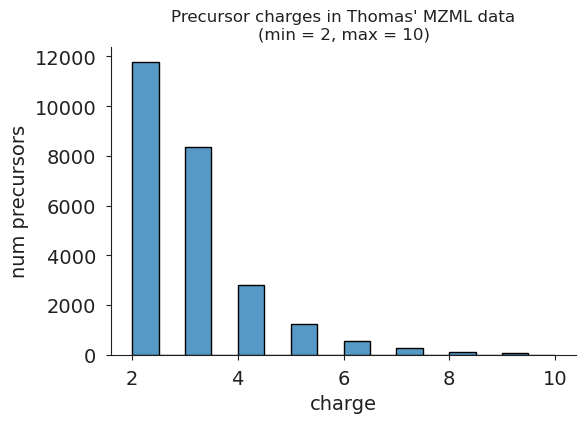

In [ ]:
from src.plot_utils import fig_setup, finalize, set_title_axes_labels
import seaborn as sns
import numpy as np

precursor_charges = [spectrum.precursor_charge for spectrum in spectra]

_, axs = fig_setup()
ax = axs[0]
_=sns.histplot(
    precursor_charges,
    ax=ax,
    binwidth=0.5,
    # bins=bins,
    # kde=True,
)
set_title_axes_labels(
    ax=ax,
    xlabel="charge",
    #  "" / (total_num_peaks)",
    ylabel="num precursors", 
    title=(
        "Precursor charges in Thomas' MZML data\n"
        f"(min = {min(precursor_charges)}, max = {max(precursor_charges)})"
    )
)
finalize(axs)
# ax.legend(loc="upper right", bbox_to_anchor=(1.5, 0.9))
# plt.tight_layout()


# Thomas validated proteins [LU: 2/28/25]

In [ ]:
from src.constants import COMET_RUN_1_DIR, GIT_REPO_DIR, SPECTRA_DIR, PROTEIN
from src.utils import flatten_list_of_lists
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from typing import Optional
import numpy as np
from src.comet_utils import CometRow




testing = True
for sample_num in np.arange(4, 10):
    files = get_sample_files(sample_num=sample_num)
    validated_proteins = read_validated_proteins_txt(
        file_path=files.validated_proteins, sample_num=sample_num
    )

    if testing:
        colms_to_show = ["database", "accession_number", PROTEIN]
        validated_proteins[colms_to_show].head(2)

    # Get unique protein names in the set of validated proteins
    uniq_valid_proteins = set(validated_proteins[PROTEIN])

    # Get the proteins that appear in the sample's Comet run 1 results
    comet_results = CometRow.from_txt(file_path=files.comet_run_1)
    comet_proteins = flatten_list_of_lists(
        [result.proteins for result in comet_results]
    )
    if testing:
        comet_proteins[:3]
    # Comet protein names look like 'sp|P99027|RLA2_MOUSE'. The 'RLA2_MOUSE' part isn't
    # included in the validated protein names so remove that part
    comet_proteins = set(["|".join(protein.split("|")[:2]) for protein in comet_proteins])

    # Compare the two sets
    shared = uniq_valid_proteins.intersection(comet_proteins)
    missing = uniq_valid_proteins - comet_proteins

    print(
        f"For sample {sample_num},\n"
        f"\t num validated proteins = {len(uniq_valid_proteins)}\n"
        f"\t num validated proteins IN Comet run 1 = {len(shared)}\n"
        f"\t num validated proteins NOT IN Comet run 1 = {len(missing)}"
    )

    if testing:
        break
    

,database,accession_number,protein
0,SwissProt,P01325,sp|P01325
1,SwissProt,P01325,sp|P01325


['tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE',
 'sp|P99027|RLA2_MOUSE',
 'sp|Q8BI84|TGO1_MOUSE']

For sample 4,
	 num validated proteins = 48
	 num validated proteins IN Comet run 1 = 32
	 num validated proteins NOT IN Comet run 1 = 16


## Are all the validated proteins in the mouse proteome?

In [75]:
from src.peptides_and_ions import get_proteins_from_fasta
from src.constants import MOUSE_PROTEOME, PROTEIN, SHORT_NAME
from src.miscellaneous import get_all_validated_proteins, remove_gene_name

# Get unique proteins in the FASTA file
fasta_proteins = get_proteins_from_fasta(fasta_path=MOUSE_PROTEOME)
uniq_fasta_proteins = set([remove_gene_name(protein.name) for protein in fasta_proteins])

# Get unique proteins of Thomas's validated proteins
valid_prots = get_all_validated_proteins()
uniq_valid_prots = set(valid_prots[SHORT_NAME].unique())

# Print results
print(
    f"There are {len(uniq_valid_prots)} unique validated proteins.\n"
    f"There are {len(uniq_valid_prots.difference(uniq_fasta_proteins))} that are validated proteins that AREN'T in the mouse proteome.\n"
    f"The missing proteins are {uniq_valid_prots.difference(uniq_fasta_proteins)}"
)

# Get human-meaningful names of the missing proteins
for p_name in uniq_valid_prots.difference(uniq_fasta_proteins):
    valid_prots[valid_prots[SHORT_NAME]==p_name]["entry_name"]


There are 144 unique validated proteins.
There are 2 that are validated proteins that AREN'T in the mouse proteome.
The missing proteins are {'sp|Q9CQ01', 'sp|Q61029'}


2214    Ribonuclease T2
Name: entry_name, dtype: object

1631    Lamina-associated polypeptide 2
Name: entry_name, dtype: object

## Abundances of validated proteins in Comet output

In [107]:
# Load data
from src.constants import RESULTS_DIR
from src.miscellaneous import comet_counts_and_valid_prots
from src.utils import pickle_and_compress, decompress_and_unpickle

save = True
df = comet_counts_and_valid_prots()

if save:
    file_path = RESULTS_DIR / "protein_abundances.pkl"
    pickle_and_compress(obj=df, file_path=file_path)  
    decompress_and_unpickle(file_path)  

2025-03-06 16:03:26,931 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn4
2025-03-06 16:03:26,945 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn5
2025-03-06 16:03:26,961 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn6
2025-03-06 16:03:26,982 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn7
2025-03-06 16:03:27,000 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn8
2025-03-06 16:03:27,018 - src.comet_utils - INFO - Reading data for BMEM_AspN_Fxn9


Here are the proteins that are in the validated list but NOT in the FASTA: {'sp|Q9CQ01', 'sp|Q61029'}


,full_name,short_name,comet_counts,validated
0,sp|P97798|NEO1_MOUSE,sp|P97798,9,0
1,sp|Q9CX83|ARMX1_MOUSE,sp|Q9CX83,2,0
2,sp|P30987|TA2R_MOUSE,sp|P30987,3,0
3,sp|Q8C5H8|NAKD2_MOUSE,sp|Q8C5H8,2,0
4,sp|Q9D035|NKAI1_MOUSE,sp|Q9D035,0,0
...,...,...,...,...
21754,sp|Q9R0Y8|GBRG1_MOUSE,sp|Q9R0Y8,2,0
21755,sp|P01648|KV5AF_MOUSE,sp|P01648,0,0
21756,sp|Q8BG47|RN152_MOUSE,sp|Q8BG47,1,0
21757,sp|Q99MR9|PPR3A_MOUSE,sp|Q99MR9,2,0


# Previous HS output

In [124]:
from src.prev_hs_output import load_hs_output
df = load_hs_output()

df["hybrid"].value_counts()


hybrid
Hybrid    146765
Native     88404
Name: count, dtype: int64